In [1]:
from pathlib import Path

In [2]:
import numpy as np
from PIL import Image

In [22]:
base_dir = Path("photos")

In [56]:
size = (1000, 666)

In [57]:
#count = 1000
statistics = []
for path in base_dir.iterdir():
    with Image.open(path) as im:
        if im.size == size:
            statistics.append(np.asarray(im).mean(axis=2).astype(np.uint8))
            #if len(images) >= count:
            #    break
statistics = np.stack(statistics)
print(f"Loaded {len(statistics)} images")

Loaded 7036 images


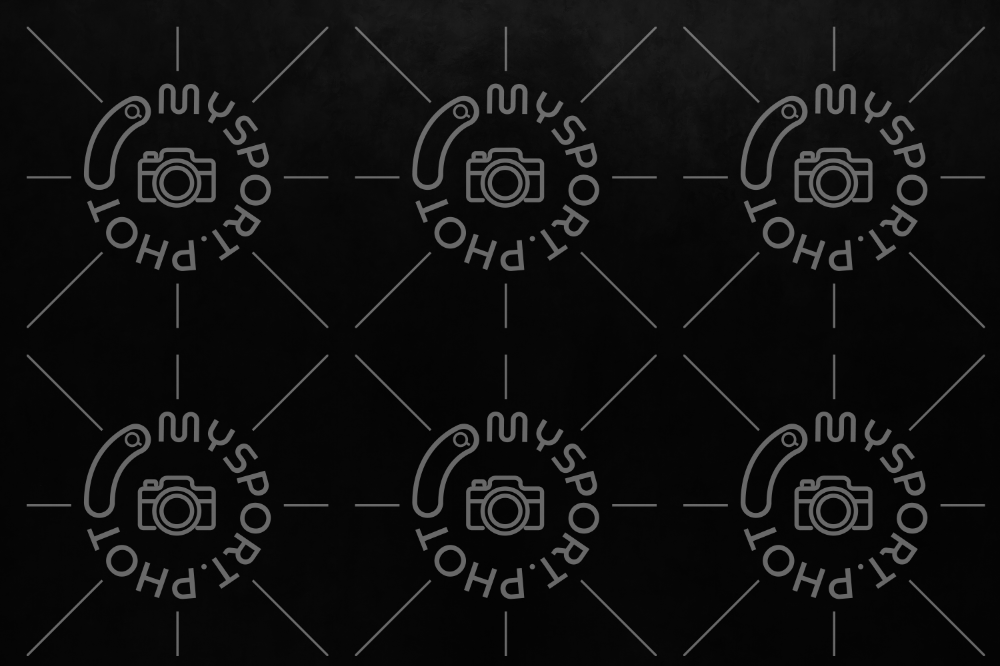

In [59]:
mask = np.quantile(statistics, 0.001, axis=0)
Image.fromarray(mask.astype(np.uint8))

In [44]:
in_dir = Path("input")
out_dir = Path("output")
out_dir.mkdir(exist_ok=True)

In [60]:
images = {}
for path in in_dir.iterdir():
    with Image.open(path) as im:
        if im.size == size:
            images[path.stem] = np.asarray(im)
print(f"Loaded {len(images)} images")

Loaded 9 images


In [31]:
def subtract(image, mask):
    x = image
    y = np.expand_dims(mask, axis=2)
    return (255.0 * ((x - y) / (255 - y)).clip(0, 1)).astype(np.uint8)

In [61]:
for name, image in images.items():
    Image.fromarray(subtract(image, mask)).save(out_dir / (name + ".png"))